## Resting state EEG (rsEEG) spectral changes associated with age

This notebook should show the steps used for preprocessing EEG for one subject.
What preprocessing steps are involved in preparing the EEG data for analysis?

Initial number of subject with EEG 201
Final number of subjects included: 181/171

- group of young adults (N=123)
- group of older adults (N=24) with higher education (12 years of lyceum/gimnasium)
- low education (N = 32) with 10 yearts of technical hight school/Realschule

The data were processed in Brainstorm (Tadel et al., 2011) using the following steps:

The reconstructed sources were projected to Destrieux parcellation (citation needed)


In [1]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2


In [2]:
from poirot.spectrum import psd_fooof, fooof2pandas
from poirot.translate import define_region_dict, prepare_grouping
from poirot.load_data import load_mat_file, plot_psd_vs_freq_roi
from glob import glob
from pathlib import Path
import xarray as xr
import pandas as pd
import re
import numpy as np

from fooof import FOOOF, FOOOFGroup
import seaborn as sb
import seaborn.objects as so
import matplotlib.pyplot as plt

sb.set_style("whitegrid")


def add_coordinate(da, coordinate, partition_dict, new_coordinate):
    temp = prepare_grouping(da, coordinate, partition_dict)
    return da.assign_coords({new_coordinate: (coordinate, temp)})


def map_regions():
    # function to go from a dict with regions roi to pandas dataframe
    my_dict = define_region_dict()

    df_list = []
    for key, value in my_dict.items():
        df = pd.DataFrame({"roi_names": value}).assign(regions=key)
        df_list.append(df)
    return pd.concat(df_list)

# Visualise PSDs


In [3]:
df_average = pd.read_csv("../data/occipital_data_OH_OL.csv").rename(
    columns={"mean_offset": "offset", "mean_exponent": "exponent"}
)

sub_list = df_average["subject"].values.tolist()

age_edu_dict = {
    level: df_average.query("`Y_OH_OL` == @level")
    .loc[:, ["subject"]]
    .T.values.tolist()[0]
    for level in ["O_H", "O_L", "Y_H"]
}

map_subjects = df_average.loc[:, ["subject", "Y_OH_OL"]]

# | loop over all subject to plot the files

# Initialize a FOOOF object, with some settings

pandas_list = []
folder = "../data/lemon_rsEEG_dataset"
files_EC = [Path(p) for p in glob(f"{folder}/*/*EO.mat")]


regions_psd = []
for path_mat in files_EC:
    sub = re.findall("sub-[0-9]{6}", str(path_mat))
    temp = load_mat_file(path_mat, sub)
    # temp_regions = temp
    if temp.freqs.values.size > 51:
        regions_psd.append(temp)

# Exclude 2 subject who were anlysed up to 50 Hz, they have much differnt fits (it turns out they are already excluded from the datset prepared in R)


da = (  # concatenate all subjects, add aditiona information about regions and grouping
    xr.concat(regions_psd, dim="sub", coords="all", join="override")
    .pipe(
        add_coordinate,
        coordinate="roi_names",
        partition_dict=define_region_dict(),
        new_coordinate="regions",
    )
    .sel(sub=sub_list)
    .pipe(
        add_coordinate,
        coordinate="sub",
        partition_dict=age_edu_dict,
        new_coordinate="Y_OH_OL",
    )
)

da.to_netcdf("../data/output/LEMON_power.nc")

# display(da)


## Plot averaged PSD across age-eduction group


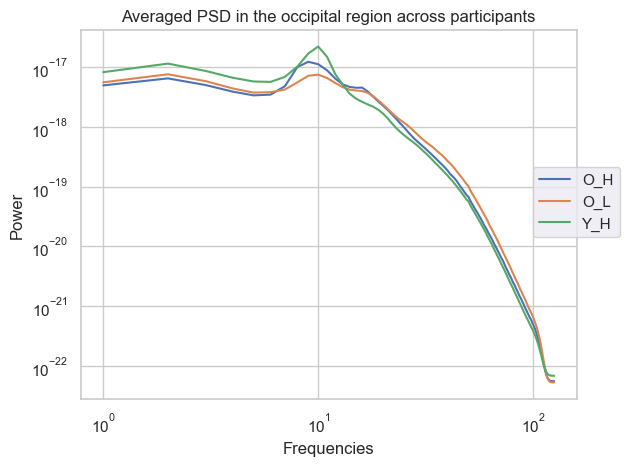

In [17]:
f, ax = plt.subplots()

p = (  # have a small dataframne to work with
    da.groupby("regions")
    .mean(dim="roi_names")
    .loc[dict(regions="occipital")]
    .groupby("Y_OH_OL")
    .mean(dim="sub")
    .to_dataframe("power")
    .pipe(so.Plot, x="freqs", y="power", color="Y_OH_OL")
    .add(so.Line())
    .scale(y="log")
    .scale(x="log")
    .label(
        x="Frequencies",
        y="Power",
        title="Averaged PSD in the occipital region across participants",
        color="",
    )
)
p.on(ax).show()


In [13]:


metadata = {'peak_width_limits': [2, 8], 'min_peak_height': 0.1, max_n_peaks}
# metadata =  {'fg': fg, 'freq_range': freq_range}

# store data as hdf5
storedata = pd.HDFStore(
    '../data/output/computed_specparam.hdf5', key='data_specparam')
storedata.put('data_specparam', df)
storedata.get_storer('data_specparam').attrs.attr_key = 'attr_value'
storedata.close()

data = pd.read_hdf('../data/output/computed_specparam.hdf5', 'r')
df = data['data_specparam']
data.close()


KeyError: 'No object named r in the file'

In [73]:
import h5py
import numpy as np

# Writing data
d1 = np.random.random(size=(1000, 20))  # Sample data
hf = h5py.File("test_data.h5", "w")
dset1 = hf.create_dataset("dataset_1", data=d1)
# set some metadata directly
hf.attrs["metadata1"] = 5

# sample dictionary object
sample_dict = {"metadata2": 1, "metadata3": 2, "metadata4": "blah_blah"}

# Store this dictionary object as hdf5 metadata
hf.attrs.update(sample_dict)
hf.close()

# Reading data
hf1 = h5py.File("test_data.h5", "r")
for name in hf1:
    print(name)

print(hf1.attrs.keys())
hf1.close()


dataset_1
<KeysViewHDF5 ['metadata1', 'metadata2', 'metadata3', 'metadata4']>


In [75]:
hf1.attrs()

ValueError: Invalid location identifier (invalid location identifier)

Running FOOOFGroup: 100%|██████████| 5/5 [00:01<00:00,  3.45it/s]


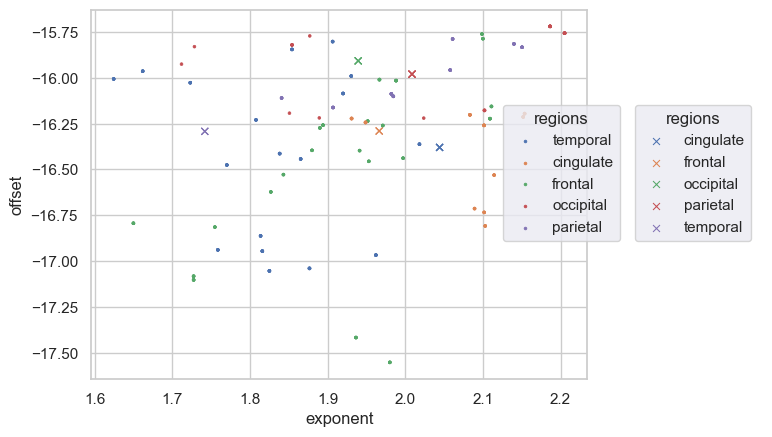

In [58]:
dap = da.isel(sub=slice(0, 1))

p = (  # just pass time series without averaging
    compute_specparam_parameters(dap, fg, freq_range, dim_second="roi_names")
    .merge(map_subjects, on="subject", how="left")
    .merge(map_regions(), on="roi_names", how="left")
    .pipe(so.Plot, x="exponent", y="offset", color="regions")
    .add(so.Dot(pointsize=2))
)

g = (  # avarage the time series among the regions first then pass the  further
    dap.groupby("regions")
    .mean(dim="roi_names")
    .pipe(
        compute_specparam_parameters, fg=fg, freq_range=freq_range, dim_second="regions"
    )
    .pipe(so.Plot, x="exponent", y="offset", color="regions")
    .add(so.Dot(pointsize=5, marker="x"))
)

h = (  # just pass time series without averaging
    compute_specparam_parameters(dap, fg, freq_range, dim_second="roi_names")
    .merge(map_subjects, on="subject", how="left")
    .merge(map_regions(), on="roi_names", how="left")
    .groupby("regions")
    .mean.pipe(so.Plot, x="exponent", y="offset", color="regions")
    .add(so.Dot(pointsize=2))
)

f, ax = plt.subplots()
s = g.on(ax).plot()
p.on(ax).show()


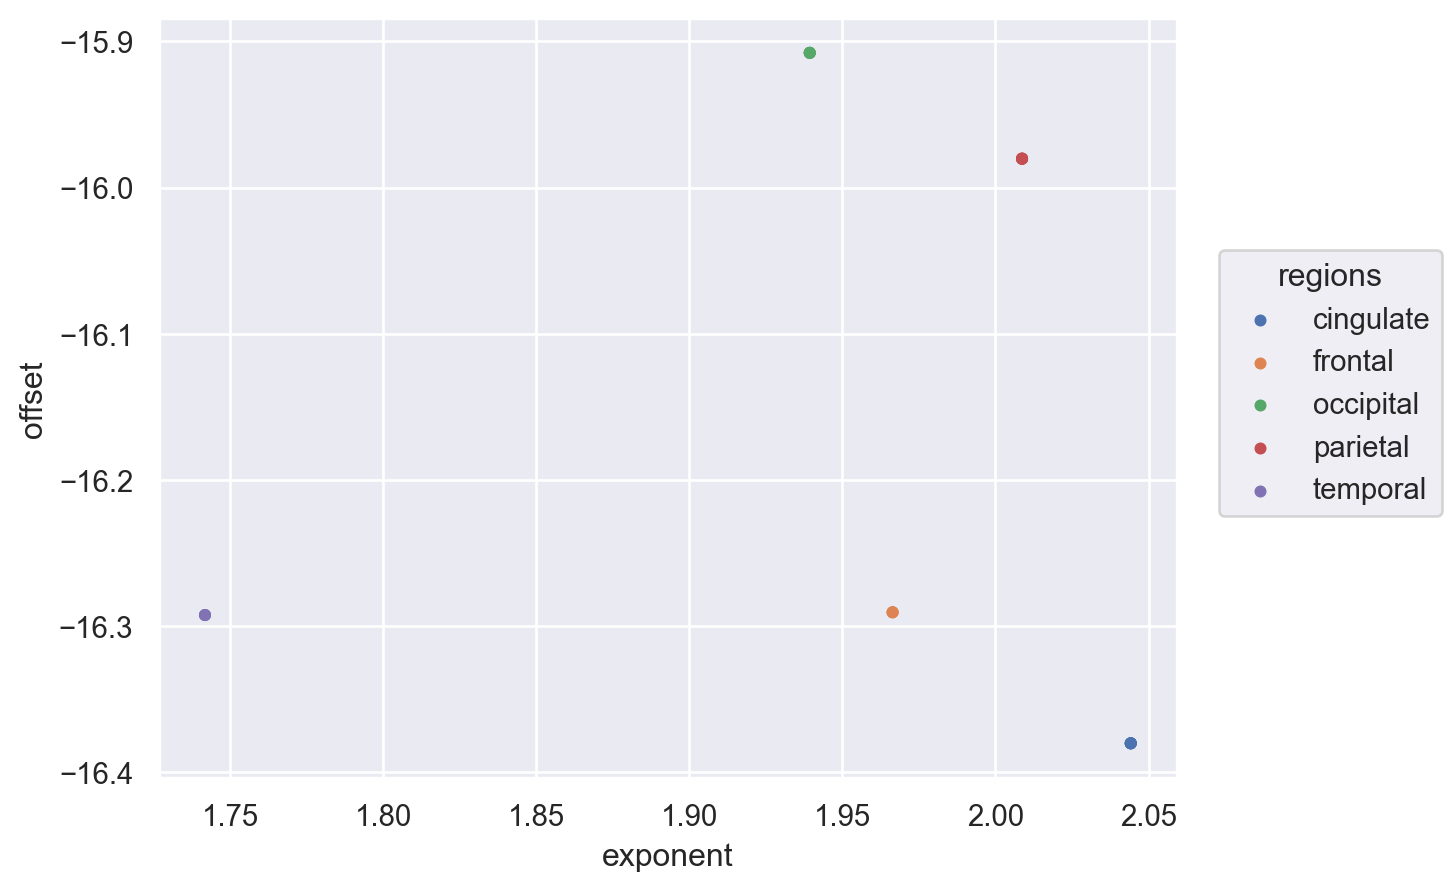

In [35]:
(so.Plot(results, x="exponent", y="offset", color="regions").add(so.Dot(pointsize=4)))
# pass the info about mappings and regions


In [ ]:
import seaborn.objects as so

da_multiplied = da_occipital * 10e18
for level in ["O_H", "O_L", "Y_H"]:
    temp_list = (
        data.query("`Y_OH_OL` == @level").loc[:,
                                              ["subject"]].T.values.tolist()[0]
    )
    da_multiplied.sel(sub=temp_list).mean(
        dim="sub").plot(xlim=[2, 50], xscale="log")

data_multiplied = param_xarray(da_multiplied)


(
    so.Plot(data_multiplied, x="exponent", y="offset", color="Y_OH_OL").add(
        so.Dot(pointsize=4)
    )
)


2 subjects were exlude they were preprocessed differently (but it shouldnt matter, thay arent in the final set)

# Visualise my results

My range of offset and exponent is not ok


In [ ]:
# do nice plotting
